In [13]:
import pandas as pd
import numpy as np
import  sklearn

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

import graphviz
import pydotplus
import io

from scipy import misc
from sklearn.metrics import accuracy_score

import spotipy
import spotipy.util as util
sp = spotipy.Spotify() 
from spotipy.oauth2 import SpotifyClientCredentials 

In [19]:
%env SPOTIPY_CLIENT_ID="      " 
%env SPOTIPY_CLIENT_SECRET="      "
%env SPOTIPY_REDIRECT_URI="http://localhost/"

scope = 'user-library-read playlist-modify-public playlist-read-private'

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret) 

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [15]:
good_playlist = sp.user_playlist("username", "playlist_uri")
good_tracks = good_playlist["tracks"]
good_songs = good_tracks["items"] 

bad_playlist = sp.user_playlist("username", "playlist_uri")
bad_tracks = bad_playlist["tracks"]
bad_songs = bad_tracks["items"] 

In [16]:
while good_tracks['next']:
    good_tracks = sp.next(good_tracks)
    for item in good_tracks["items"]:
        good_songs.append(item)
good_ids = [] 
print(len(good_songs))
for i in range(len(good_songs)):
    good_ids.append(good_songs[i]['track']['id'])
good_tracks
    

print(good_songs[1]['track']['id'])
print(good_songs[1]['track']['name'])

352
1bYnvQcNHNIuBFs3OSHlW5
Walk with You


In [17]:
while bad_tracks['next']:
    bad_tracks = sp.next(bad_tracks)
    for item in bad_tracks["items"]:
        bad_songs.append(item)
bad_ids = [] 
print(len(bad_songs))
for i in range(len(bad_songs)):
    bad_ids.append(bad_songs[i]['track']['id'])
bad_tracks
    

print(bad_songs[1]['track']['id'])
print(bad_songs[1]['track']['name'])

378
47FyQCd3TYLrZ9TU6MPaWK
Ace Of Spades


In [18]:
ogtrack_ids = []
ogtrack_names = []
for i in range(0,len(good_ids)):
    if good_songs[i]['track']['id'] != None: 
        ogtrack_ids.append(good_songs[i]['track']['id'])
        ogtrack_names.append(good_songs[i]['track']['name'])
for i in range(0,len(bad_ids)):
    if bad_songs[i]['track']['id'] != None: 
        ogtrack_ids.append(bad_songs[i]['track']['id'])
        ogtrack_names.append(bad_songs[i]['track']['name'])
        
features = []
for i in range(0,len(good_ids)):
    audio_features = sp.audio_features(good_ids[i])
    for track in audio_features:
        features.append(track)
        features[-1]['target'] = 1
for i in range(0,len(bad_ids),50):
    audio_features = sp.audio_features(bad_ids[i:i+50])
    for track in audio_features:
        features.append(track)
        features[-1]['target'] = 0

In [19]:
trainingData = pd.DataFrame(features, index=ogtrack_names)

trainingData=trainingData[["id", "target", "acousticness", "danceability", "duration_ms", 
                         "energy", "instrumentalness",  "key", "liveness",
                         "loudness", "mode", "speechiness", "tempo", "valence"]]

trainingData.head()

,id,target,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
That Was Your Mother - Gui Boratto Remix,7qB5mBa997C6ddiCgmsfU4,1,0.01120,0.736,377173,0.576,0.116000,5,0.0708,-9.422,1,0.0416,115.002,0.319
Walk with You,1bYnvQcNHNIuBFs3OSHlW5,1,0.33400,0.794,170240,0.614,0.006600,2,0.1160,-7.510,1,0.0861,114.026,0.251
Valerie,5EObbWJGbZxmJd3oLQuTtl,1,0.00978,0.927,228571,0.377,0.000026,11,0.0564,-9.180,1,0.0548,105.000,0.561
Get It Right,74ZQkrS93fcV6fcRYxqjjK,1,0.61800,0.747,239200,0.301,0.014900,2,0.0799,-11.882,1,0.0382,84.033,0.465
Dragonflies - Cantoma Remix,7wwFrG698IVMD73QqbC9WW,1,0.22500,0.773,342293,0.526,0.858000,4,0.0862,-12.114,1,0.0362,119.983,0.908


In [20]:
train, test = train_test_split(trainingData, test_size = 0.15)
print("Training size: {}, Test size: {}".format(len(train),len(test)))

Training size: 619, Test size: 110


In [21]:
red_blue = ['#19B5FE', '#EF4836']
palette = sns.color_palette(red_blue)
sns.set_palette(palette)
sns.set_style('white')

In [22]:
pos_tempo = trainingData[trainingData['target'] == 1]['tempo']
neg_tempo = trainingData[trainingData['target'] == 0]['tempo']
pos_dance = trainingData[trainingData['target'] == 1]['danceability']
neg_dance = trainingData[trainingData['target'] == 0]['danceability']
pos_duration = trainingData[trainingData['target'] == 1]['duration_ms']
neg_duration = trainingData[trainingData['target'] == 0]['duration_ms']
pos_loudness = trainingData[trainingData['target'] == 1]['loudness']
neg_loudness = trainingData[trainingData['target'] == 0]['loudness']
pos_speechiness = trainingData[trainingData['target'] == 1]['speechiness']
neg_speechiness = trainingData[trainingData['target'] == 0]['speechiness']
pos_valence = trainingData[trainingData['target'] == 1]['valence']
neg_valence = trainingData[trainingData['target'] == 0]['valence']
pos_energy = trainingData[trainingData['target'] == 1]['energy']
neg_energy = trainingData[trainingData['target'] == 0]['energy']
pos_acousticness = trainingData[trainingData['target'] == 1]['acousticness']
neg_acousticness = trainingData[trainingData['target'] == 0]['acousticness']
pos_key = trainingData[trainingData['target'] == 1]['key']
neg_key = trainingData[trainingData['target'] == 0]['key']
pos_instrumentalness = trainingData[trainingData['target'] == 1]['instrumentalness']
neg_instrumentalness = trainingData[trainingData['target'] == 0]['instrumentalness']

print(pos_tempo)
print(neg_tempo)

That Was Your Mother - Gui Boratto Remix    115.002
Walk with You                               114.026
Valerie                                     105.000
Get It Right                                 84.033
Dragonflies - Cantoma Remix                 119.983
                                             ...   
Passionfruit                                111.980
Pass the Vibes                              140.022
Smokers Delight                             113.999
Una Massive Sunshine                         96.022
The Wheel                                   180.038
Name: tempo, Length: 351, dtype: float64
Paranoid                                             162.780
Ace Of Spades                                        140.245
Crazy Train                                          137.571
The Number Of The Beast - 1998 Remastered Version     99.641
Hallowed Be Thy Name - 1998 Remastered Version       103.990
                                                      ...   
Over My Head         

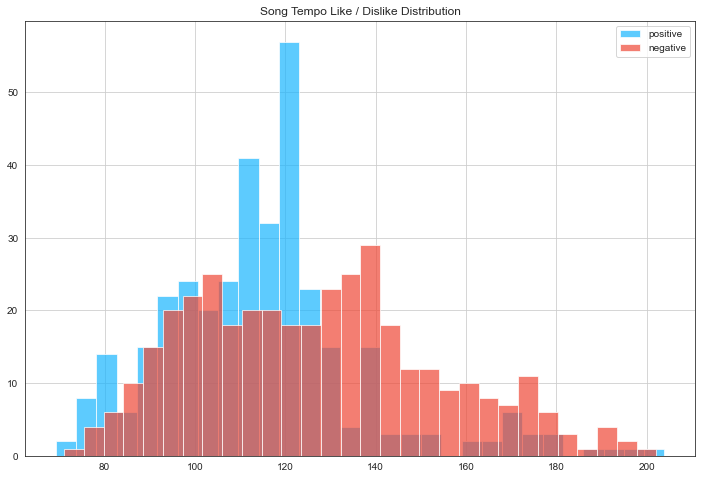

In [23]:
fig = plt.figure(figsize=(12,8))
plt.title("Song Tempo Like / Dislike Distribution")
pos_tempo.hist(alpha=0.7, bins=30, label='positive')
neg_tempo.hist(alpha=0.7, bins=30, label='negative')
plt.legend(loc='upper right')

<AxesSubplot:>

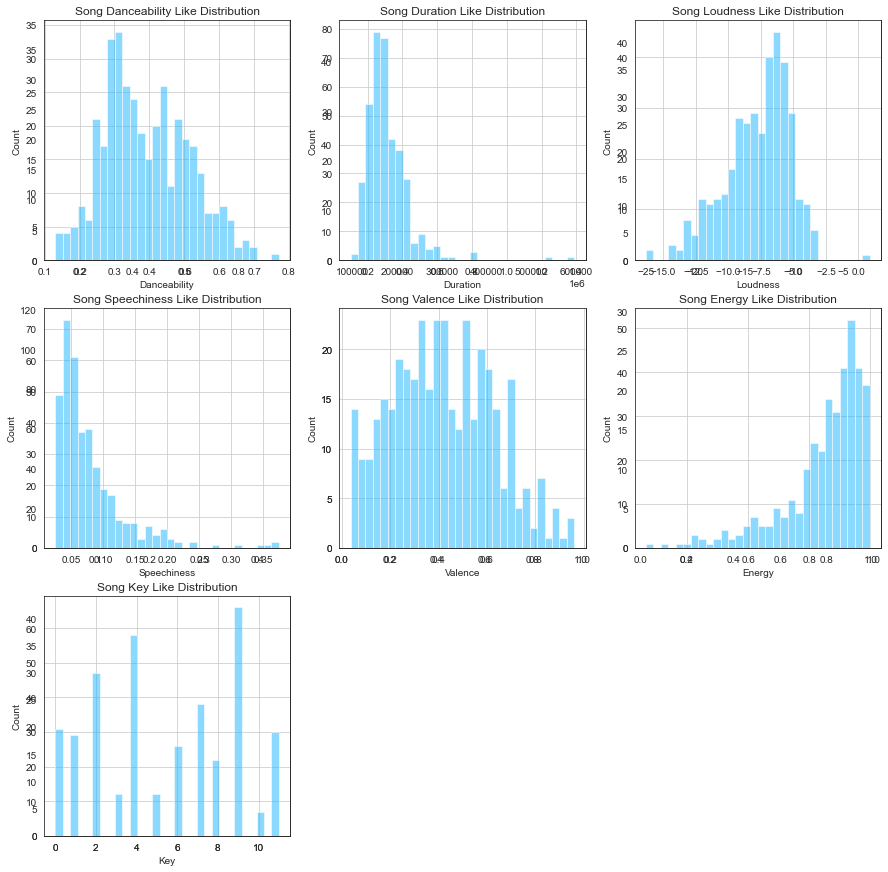

In [24]:
fig2 = plt.figure(figsize=(15,15))

#Danceability
ax3 = fig2.add_subplot(331)
ax3.set_xlabel('Danceability')
ax3.set_ylabel('Count')
ax3.set_title('Song Danceability Like Distribution')
pos_dance.hist(alpha= 0.5, bins=30)
ax4 = fig2.add_subplot(331)
neg_dance.hist(alpha= 0.5, bins=30)

#Duration_ms
ax5 = fig2.add_subplot(332)
ax5.set_xlabel('Duration')
ax5.set_ylabel('Count')
ax5.set_title('Song Duration Like Distribution')
pos_duration.hist(alpha= 0.5, bins=30)
ax6 = fig2.add_subplot(332)
neg_duration.hist(alpha= 0.5, bins=30)

#Loudness
ax7 = fig2.add_subplot(333)
ax7.set_xlabel('Loudness')
ax7.set_ylabel('Count')
ax7.set_title('Song Loudness Like Distribution')
pos_loudness.hist(alpha= 0.5, bins=30)
ax8 = fig2.add_subplot(333)
neg_loudness.hist(alpha= 0.5, bins=30)

#Speechiness
ax9 = fig2.add_subplot(334)
ax9.set_xlabel('Speechiness')
ax9.set_ylabel('Count')
ax9.set_title('Song Speechiness Like Distribution')
pos_speechiness.hist(alpha= 0.5, bins=30)
ax10 = fig2.add_subplot(334)
neg_speechiness.hist(alpha= 0.5, bins=30)

#Valence
ax11 = fig2.add_subplot(335)
ax11.set_xlabel('Valence')
ax11.set_ylabel('Count')
ax11.set_title('Song Valence Like Distribution')
pos_valence.hist(alpha= 0.5, bins=30)
ax12 = fig2.add_subplot(335)
neg_valence.hist(alpha= 0.5, bins=30)

#Energy
ax13 = fig2.add_subplot(336)
ax13.set_xlabel('Energy')
ax13.set_ylabel('Count')
ax13.set_title('Song Energy Like Distribution')
pos_energy.hist(alpha= 0.5, bins=30)
ax14 = fig2.add_subplot(336)
neg_energy.hist(alpha= 0.5, bins=30)

#Key
ax15 = fig2.add_subplot(337)
ax15.set_xlabel('Key')
ax15.set_ylabel('Count')
ax15.set_title('Song Key Like Distribution')
pos_key.hist(alpha= 0.5, bins=30)
ax16 = fig2.add_subplot(337)
neg_key.hist(alpha= 0.5, bins=30)

#Key
#ax15 = fig2.add_subplot(338)
#ax15.set_xlabel('Popularity')
#ax15.set_ylabel('Count')
#ax15.set_title('Popularity Distribution')
#pos_popularity.hist(alpha= 0.5, bins=30)
#ax16 = fig2.add_subplot(338)
#neg_popularity.hist(alpha= 0.5, bins=30)

In [26]:
#Defining feature set:
analysis_features = ["danceability", "loudness", "valence", "energy", "instrumentalness", "acousticness", "key", "speechiness","duration_ms"]

In [27]:
#Split the data into x and y test and train sets to feed them into a bunch of classifiers!
x_train = train[analysis_features]
y_train = train["target"]

x_test = test[features]
y_test = test["target"]

In [28]:
#Decision Tree Classifier - helpful to visualise
c = DecisionTreeClassifier(min_samples_split=100)
dt = c.fit(x_train, y_train)
y_pred = c.predict(x_test)
score = accuracy_score(y_test, y_pred) * 100

print("Accuracy using Decision Tree:", round(score,1), "%")

Accuracy using Decision Tree: 88.2 %


In [29]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train, y_train)
mlp_pred = mlp.predict(x_test)
score = accuracy_score(y_test, mlp_pred) * 100
print("Accuracy using mlp Tree: ", round(score, 1), "%")

Accuracy using mlp Tree:  45.5 %


In [30]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(3)
knn.fit(x_train, y_train)
knn_pred = c.predict(x_test)
score = accuracy_score(y_test, knn_pred) * 100
print("Accuracy using Knn Tree: ", round(score, 1), "%")

Accuracy using Knn Tree:  88.2 %


In [31]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.1, max_depth=1, random_state=0)
gbc.fit(x_train, y_train)
predicted = gbc.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Gbc: ", round(score, 1), "%")

Accuracy using Gbc:  95.5 %


In [32]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
forest.fit(x_train, y_train)
forest_pred = forest.predict(x_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, forest_pred) * 100
print("Accuracy using random forest: ", round(score, 1), "%")

Accuracy using random forest:  90.0 %


In [33]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3, random_state=0)
k_means.fit(x_train, y_train)
predicted= k_means.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Kmeans: ", round(score, 1), "%")

Accuracy using Kmeans:  44.5 %


In [98]:
SourcePlaylist = sp.user_playlist("spotify", "playlist_id")
tracks = SourcePlaylist["tracks"]
songs = tracks["items"] 

track_ids=[]
track_names=[]

#Creating a dataframe of the playlist
song_ids = []
print(len(songs))
for i in range(0, len(songs)):
    if songs[i]['track']['id'] != None:
        track_ids.append(songs[i]['track']['id'])
        track_names.append(songs[i]['track']['name'])
    
Newfeatures = []
j = 0
for i in range(0,len(track_ids)):
    audio_features_training = sp.audio_features(track_ids[i])
    for track in audio_features_training:
        track['song_title'] = songs[j]['track']['name']
        track['artist'] = songs[j]['track']['artists'][0]['name']
        track['uri']=songs[j]['track']['uri']
        j=j+1
        Newfeatures.append(track)

 
NewPlaylist = pd.DataFrame(Newfeatures)

NewPlaylist_df=NewPlaylist[["id", "song_title", "artist", "acousticness", "danceability", "duration_ms", 
                         "energy", "instrumentalness",  "key", "liveness",
                         "loudness", "mode", "speechiness", "tempo", "valence", "uri"]]
  

NewPlaylist_df.head()

30


,id,song_title,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,uri
0,1ructZDtKxSKcLiYPwhNGs,Someone That Loves You '19,Izzy Bizu,0.00946,0.567,245525,0.825,0.000012,6,0.2210,-4.845,0,0.0447,104.003,0.512,spotify:track:1ructZDtKxSKcLiYPwhNGs
1,5rcGQIrv6eUIyCBfWga363,Borderline,Jordan Rakei,0.34100,0.546,255240,0.595,0.000546,5,0.0861,-7.305,1,0.0441,92.146,0.230,spotify:track:5rcGQIrv6eUIyCBfWga363
2,5JEnzGH3C2PnNnKZwjyLyJ,More Than Friends,Andrey Azizov,0.71400,0.730,251126,0.474,0.025000,5,0.1230,-9.192,0,0.0390,151.055,0.249,spotify:track:5JEnzGH3C2PnNnKZwjyLyJ
3,1aWilNgXLwSLKuTHLSmtRY,Show Me,TÂCHES,0.45000,0.850,279344,0.590,0.815000,9,0.1200,-10.123,0,0.0825,122.015,0.541,spotify:track:1aWilNgXLwSLKuTHLSmtRY
4,33vdDZDNBKsllkbZXFYUD4,I Love You,Patrick Lite,0.08710,0.774,158087,0.680,0.059500,10,0.1100,-6.587,0,0.0277,115.006,0.464,spotify:track:33vdDZDNBKsllkbZXFYUD4


In [100]:
pred = gbc.predict(NewPlaylist_df[features])

Predicted_likedSongs = 0
i = 0
for prediction in pred:
    if(prediction == 1):
        print ("Song: " + NewPlaylist_df["song_title"][i] + ", By: "+ NewPlaylist_df["artist"][i])
        sp.user_playlist_add_tracks("username", "playlist_id", [NewPlaylist_df['uri'][i]])
        Predicted_likedSongs = Predicted_likedSongs + 1
    i = i +1
print(Predicted_likedSongs)


# predicting like songs - adding to playlist

Song: Borderline, By: Jordan Rakei
Song: More Than Friends, By: Andrey Azizov
Song: Show Me, By: TÂCHES
Song: I Love You, By: Patrick Lite
Song: Hold On, By: Ames
Song: Baby Blue Eyes, By: Mathilda Homer
Song: Electric Blue, By: Satin Jackets
Song: Come Home, By: Du0
Song: Awake, Animal 4 U, By: New Body Electric
Song: Can't Get Over You, By: Godford
Song: You - Mixed, By: Mk.gee
Song: Yefkir Engurguro - Mixed, By: Hailu Mergia
Song: Pain Au Chocolat, By: JHAS
Song: Summer Nights, By: Mace
Song: Julia (Deep Diving), By: Fred again..
Song: When You're Lonely, By: Cash+David
Song: Blue Lights, By: Lonely in the Rain
Song: Something Good, By: The Lagoons
Song: Tell Me, By: Conor Albert
Song: Night Rain, By: Crazy P
Song: Water Flow (Hazey Eyes Remix), By: Klyne
Song: Time, By: SG Lewis
Song: Don't Give Up, By: Groove Armada
Song: The Whistle Song - House Kitsuné America, By: Allen French
Song: Paradise, By: Kowloon
Song: Back To The Roots Of Love - Saib Remix, By: NTEIBINT
Song: L.Y.E, By

In [83]:
# Generate a new column for recommended tracks
# Set recommendation limit to the Playlist Length per track
# Check documentation for  recommendations; https://beta.developer.spotify.com/documentation/web-api/reference/browse/get-recommendations/

NewPlaylist_df['track_recs']=NewPlaylist_df['id'].apply(lambda x: [(track['id']) for track in 
                                                  sp.recommendations(seed_tracks=[x], limit=len(NewPlaylist_df))['tracks']])

# Take a look at recommended tracks for the first track
for track in sp.tracks(NewPlaylist_df['track_recs'][0])['tracks']:
    print(track['name'] + ' - ' + track['artists'][0]['name'] + ' - ' + track['external_urls']['spotify'])

Don't Leave Me Lonely (feat. YEBBA) - Mark Ronson - https://open.spotify.com/track/68e673a92s9HYTeZQD3sBX
Californian Soil - London Grammar - https://open.spotify.com/track/5hR2CzTCqkuKRWFkphBS9M
Inside Friend (feat. John Mayer) - Leon Bridges - https://open.spotify.com/track/4ehkZtzPTbjsRULRfQSWYu
Mara - Jack Garratt - https://open.spotify.com/track/2OkzpTEv6BhrYBGchpdoc3
Hell N Back - Bakar - https://open.spotify.com/track/3NRql0A1Ef4RCvT473iqgD
Last Request - Paolo Nutini - https://open.spotify.com/track/2UXO3rKTfsfPieGDQHgG6q
Need Somebody To Love - Ady Suleiman - https://open.spotify.com/track/6tDhad33YnPXOq01Qxt9d1
Lights On - Izzy Bizu - https://open.spotify.com/track/0vpBmYdeqltCcOpufZCLcx
Reason To Stay - Olivia Dean - https://open.spotify.com/track/56DxR1jHbX6xlGwZdUuN0v
Nervous Tics (feat. Holly Walker) - Maribou State - https://open.spotify.com/track/2oJ8Il24SIiDCJv39RYzPp
Feels Like a Sunday - Elderbrook - https://open.spotify.com/track/1ejVZdZLqAsDjdq3fFzaeH
Shine - Emeli

<ipython-input-83-8ca86740b14c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NewPlaylist_df['track_recs']=NewPlaylist_df['id'].apply(lambda x: [(track['id']) for track in
